[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# UNet

To run this notebook, you will need to download the dataset from Kaggle's [Carvana Image Masking Challenge](https://www.kaggle.com/c/carvana-image-masking-challenge)

inspiration from https://github.com/milesial/Pytorch-UNet



In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, datasets as dset
import torchvision.utils as vutils

In [3]:
from zipfile import ZipFile
from tqdm import tqdm
from glob import glob
from PIL import Image
import numpy as np
import random
from matplotlib import pyplot as plt

## Loading data and creating datasets and dataloaders

In [4]:
import os
from pathlib import Path

ROOT_DIR = Path.home()
data_path = os.path.join(ROOT_DIR,'data/')

In [5]:
# extract train data, need to be done only once.
#with ZipFile(data_path+'carvana-image-masking-challenge/train.zip', 'r') as zf:
#    zf.extractall(data_path+'carvana-image-masking-challenge/working')
     
#with ZipFile(data_path+'carvana-image-masking-challenge/train_masks.zip', 'r') as zf:
#    zf.extractall(data_path+'carvana-image-masking-challenge/working')

In [6]:
class MyDataset(Dataset):
    def __init__(self, root_dir: str, train=True, transforms=None):
        super(MyDataset, self).__init__()
        self.train = train
        self.transforms = transforms
        
        file_path = root_dir + 'train/*.*'
        file_mask_path = root_dir + 'train_masks/*.*'
        
        self.images = sorted(glob(file_path))
        self.image_mask = sorted(glob(file_mask_path))
        
        # manually split the train/valid data
        split_ratio = int(len(self.images) * 0.7)
        if train:
            self.images = self.images[:split_ratio]
            self.image_mask = self.image_mask[:split_ratio]
        else:
            self.images = self.images[split_ratio:]
            self.image_mask = self.image_mask[split_ratio:]
        
        
    def __getitem__(self, index: int):
        image = Image.open(self.images[index]).convert('RGB')
        image_mask = Image.open(self.image_mask[index]).convert('L')

        
        if self.transforms:
            image = self.transforms(image)
            image_mask = self.transforms(image_mask)
                        
        return {'img': image, 'mask': image_mask}
    
    def __len__(self):
        return len(self.images)

In [7]:
batch_size = 16
n_workers = 2


width = 256
height = 256
channels = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

seed = 44
random.seed(seed);
torch.manual_seed(seed);

In [8]:
transforms = T.Compose([
    T.Resize((width, height)),
    T.ToTensor(),
])
train_dataset = MyDataset(root_dir=data_path+'carvana-image-masking-challenge/working/',
                                 train=True,
                                 transforms=transforms)
val_dataset = MyDataset(root_dir=data_path+'carvana-image-masking-challenge/working/',
                                train=False,
                                transforms=transforms)

train_dataset_loader = DataLoader(dataset=train_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=n_workers)
val_dataset_loader = DataLoader(dataset=val_dataset,
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=n_workers)

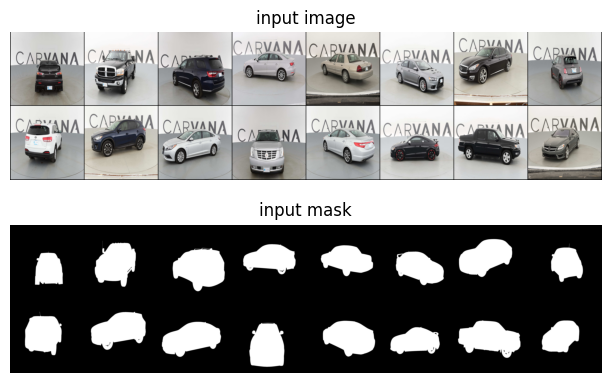

In [9]:
samples = next(iter(train_dataset_loader))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))
fig.tight_layout()


ax1.axis('off')
ax1.set_title('input image')
ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                       (1, 2, 0)))

ax2.axis('off')
ax2.set_title('input mask')
ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                       (1, 2, 0)), cmap='gray')

plt.show()

## UNet architecture

![](https://raw.githubusercontent.com/dataflowr/website/master/modules/extras/unet/unet.png)

In [10]:
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

class down_layer(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down_layer, self).__init__()
        self.pool = nn.MaxPool2d(2, stride=2, padding=0)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(self.pool(x))
        return x

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()
        self.up_scale = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)

    def forward(self, x1, x2): # x1 (bs,out_ch,w1,h1) x2 (bs,in_ch,w2,h2)
        x2 = self.up_scale(x2) # (bs,out_ch,2*w2,2*h2)
        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2]) # (bs,out_ch,w1,h1)
        x = torch.cat([x2, x1], dim=1) # (bs,2*out_ch,w1,h1)
        return x

class up_layer(nn.Module):
    def __init__(self, in_ch, out_ch): # !! 2*out_ch = in_ch !!
        super(up_layer, self).__init__()
        self.up = up(in_ch, out_ch)
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2): # x1 (bs,out_ch,w1,h1) x2 (bs,in_ch,w2,h2)
        a = self.up(x1, x2) # (bs,2*out_ch,w1,h1)
        x = self.conv(a) # (bs,out_ch,w1,h1) because 2*out_ch = in_ch
        return x

In [11]:
in_ch = 8
out_ch = 4
up_test = up(in_ch,out_ch)
x_1 = torch.randn(batch_size,out_ch,256,256)
x_2 = torch.randn(batch_size,in_ch,127,125)

In [12]:
y = up_test(x_1,x_2)
y.shape

torch.Size([16, 8, 256, 256])

In [13]:
up_test = up_layer(in_ch,out_ch)

In [14]:
y = up_test(x_1,x_2)
y.shape

torch.Size([16, 4, 256, 256])

In [15]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.conv1 = double_conv(in_channels, 64)
        self.down1 = down_layer(64, 128)
        self.down2 = down_layer(128, 256)
        self.down3 = down_layer(256, 512)
        self.down4 = down_layer(512, 1024)
        self.up1 = up_layer(1024, 512)
        self.up2 = up_layer(512, 256)
        self.up3 = up_layer(256, 128)
        self.up4 = up_layer(128, 64)
        self.last_conv = nn.Conv2d(64, out_channels, 1)

    def forward(self, x): # (bs,in_channels,w,d)
        x1 = self.conv1(x) # (bs,64,w,d)
        x2 = self.down1(x1) # (bs,128,w/2,d/2)
        x3 = self.down2(x2) # (bs,256,w/4,d/4)
        x4 = self.down3(x3) # (bs,512,w/8,h/8)
        x5 = self.down4(x4) # (bs,1024,w/16,h/16)
        x1_up = self.up1(x4, x5) # (bs,512,w/8,h/8)
        x2_up = self.up2(x3, x1_up) # (bs,256,w/4,h/4)
        x3_up = self.up3(x2, x2_up) # (bs,128,w/2,h/2)
        x4_up = self.up4(x1, x3_up) # (bs,64,w,h)
        output = self.last_conv(x4_up) # (bs,out_channels,w,h)
        return output

In [16]:
model = UNet(in_channels=3, out_channels=1)

In [17]:
x = torch.randn(batch_size,3,256,128)
y = model(x)

In [18]:
y.shape

torch.Size([16, 1, 256, 128])

## Metrics

[Sørensen–Dice coefficient](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)

In [19]:
def dice_score(pred: torch.Tensor, mask: torch.Tensor):
    dice = (2 * (pred * mask).sum()) / (pred + mask).sum()
    return np.mean(dice.cpu().numpy())

def pixel_accuracy(pred: torch.Tensor, mask: torch.Tensor):
    correct = torch.eq(pred, val_mask).int()
    return float(correct.sum()) / float(correct.numel())

In [20]:
def plot_pred_img(samples, pred):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(12, 6))
    fig.tight_layout()


    ax1.axis('off')
    ax1.set_title('input image')
    ax1.imshow(np.transpose(vutils.make_grid(samples['img'], padding=2).numpy(),
                           (1, 2, 0)))

    ax2.axis('off')
    ax2.set_title('input mask')
    ax2.imshow(np.transpose(vutils.make_grid(samples['mask'], padding=2).numpy(),
                           (1, 2, 0)), cmap='gray')
    
    ax3.axis('off')
    ax3.set_title('predicted mask')
    ax3.imshow(np.transpose(vutils.make_grid(pred, padding=2).cpu().numpy(),
                           (1, 2, 0)), cmap='gray')

    plt.show()
    
    
def plot_train_progress(model):
    samples = next(iter(val_dataset_loader))
    val_img = samples['img'].to(device)
    val_mask = samples['mask'].to(device)

    pred = model(val_img)


    plot_pred_img(samples, pred.detach())

## Training loop

In [21]:
def train(model, optimizer, criteration, scheduler=None):
    train_losses = []
    val_lossess = []
    lr_rates = []
    
    # calculate train epochs
    #epochs = int(n_iters / (len(train_dataset) / batch_size))


    for epoch in range(epochs):
        model.train()        
        train_total_loss = 0
        train_iterations = 0
        
        for idx, data in enumerate(tqdm(train_dataset_loader)):
            train_iterations += 1
            train_img = data['img'].to(device)
            train_mask = data['mask'].to(device)
            
            optimizer.zero_grad()
            with torch.autocast(device_type='cuda'):
                train_output_mask = model(train_img)
                train_loss = criterion(train_output_mask, train_mask)
                train_total_loss += train_loss.item()

            train_loss.backward()
            optimizer.step()


        train_epoch_loss = train_total_loss / train_iterations
        train_losses.append(train_epoch_loss)
        
        # evaluate mode
        model.eval()
        with torch.no_grad():
            val_total_loss = 0
            val_iterations = 0
            scores = 0

            for vidx, val_data in enumerate(tqdm(val_dataset_loader)):
                val_iterations += 1
                val_img = val_data['img'].to(device)
                val_mask = val_data['mask'].to(device)

                with torch.autocast(device_type='cuda'):
                    pred = model(val_img)
                    val_loss = criterion(pred, val_mask)
                    val_total_loss += val_loss.item()
                    scores += dice_score(pred, val_mask)


            val_epoch_loss = val_total_loss / val_iterations
            dice_coef_scroe = scores / val_iterations

            val_lossess.append(val_epoch_loss)           

            plot_train_progress(model)
            print('epochs - {}/{} [{}/{}], dice score: {}, train loss: {}, val loss: {}'.format(
                epoch+1, epochs,
                idx+1, len(train_dataset_loader),
                dice_coef_scroe, train_epoch_loss, val_epoch_loss
            )) 
            
        lr_rates.append(optimizer.param_groups[0]['lr'])
        if scheduler:
            scheduler.step(val_epoch_loss) # decay learning rate
            
            
    return {
        'lr': lr_rates,
        'train_loss': train_losses,
        'valid_loss': val_lossess
    }


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


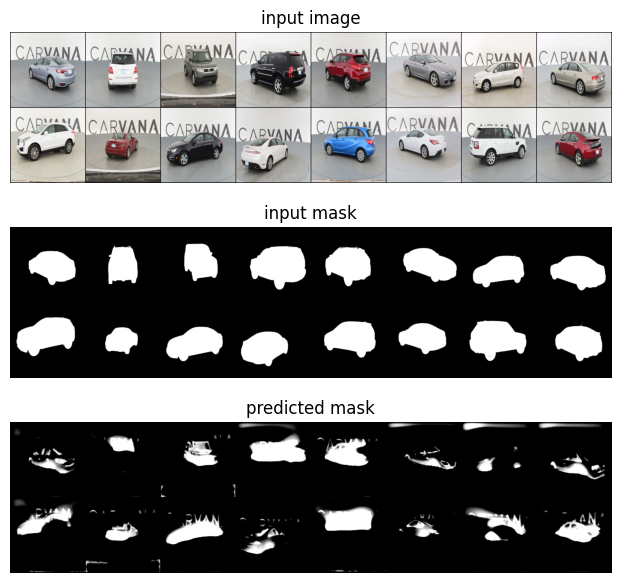

epochs - 1/10 [223/223], dice score: 0.3563343877904117, train loss: 0.4693181104456897, val loss: 0.6461361615608135


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.75it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


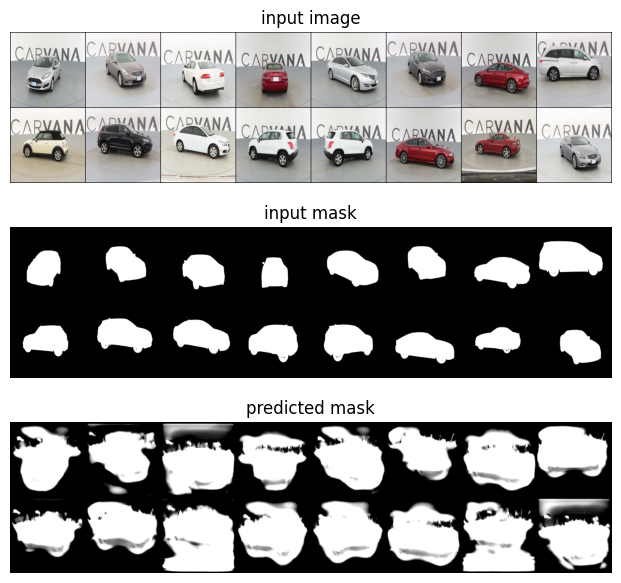

epochs - 2/10 [223/223], dice score: 1.358413973202308, train loss: 0.3727507885261501, val loss: 0.8961436891307434


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


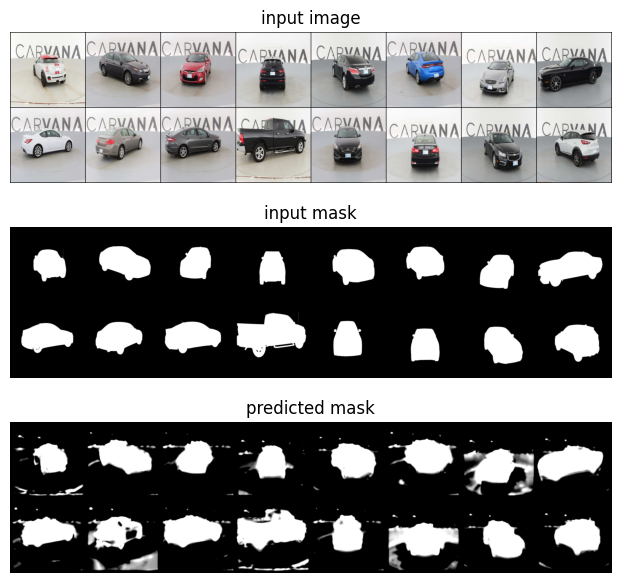

epochs - 3/10 [223/223], dice score: 4.390798901518186, train loss: 0.29771160731935714, val loss: 0.33039285335689783


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.72it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


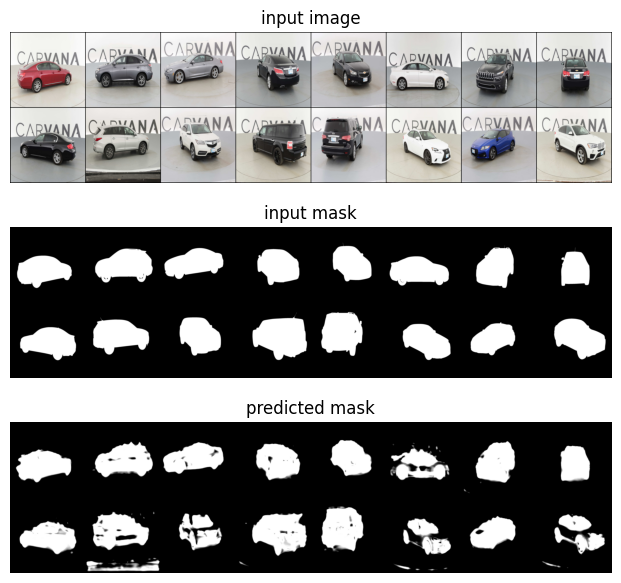

epochs - 4/10 [223/223], dice score: -1.254819901039203, train loss: 0.23398686116853637, val loss: 0.18078864738345146


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.74it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


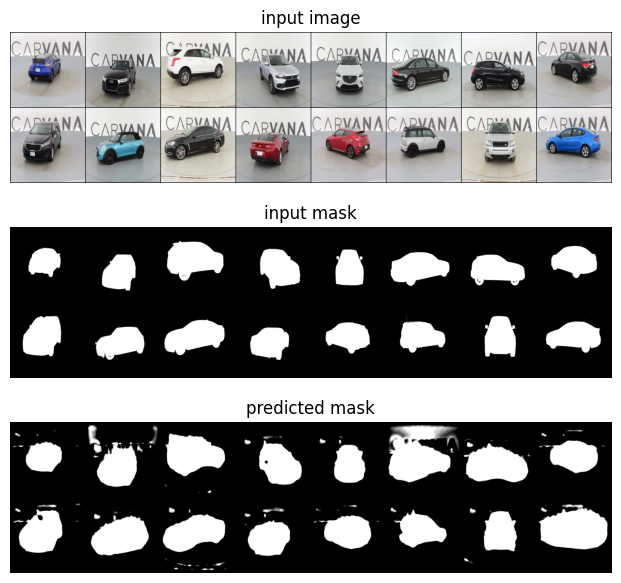

epochs - 5/10 [223/223], dice score: 4.356011966864268, train loss: 0.2074748266304555, val loss: 0.3500659704829256


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


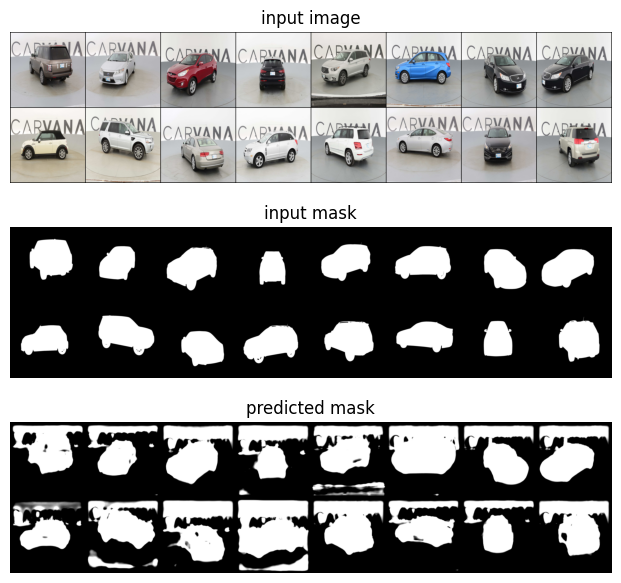

epochs - 6/10 [223/223], dice score: 2.412823868294557, train loss: 0.180490334071386, val loss: 0.6184888270994028


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.73it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


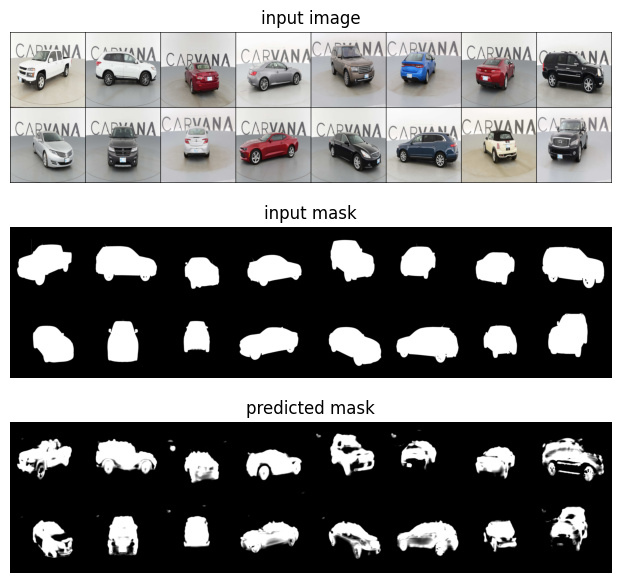

epochs - 7/10 [223/223], dice score: -1.2875102249284585, train loss: 0.16553026985694475, val loss: 0.24357885293041667
Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


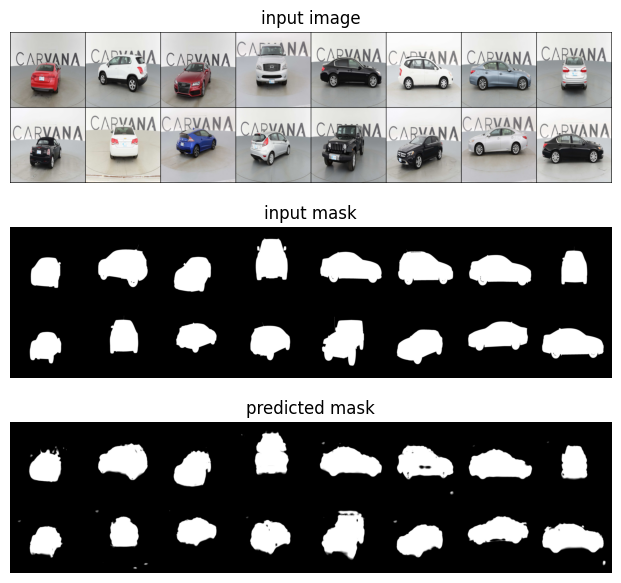

epochs - 8/10 [223/223], dice score: -2.1362797965606055, train loss: 0.1531652911094272, val loss: 0.17285136630137762


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.69it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


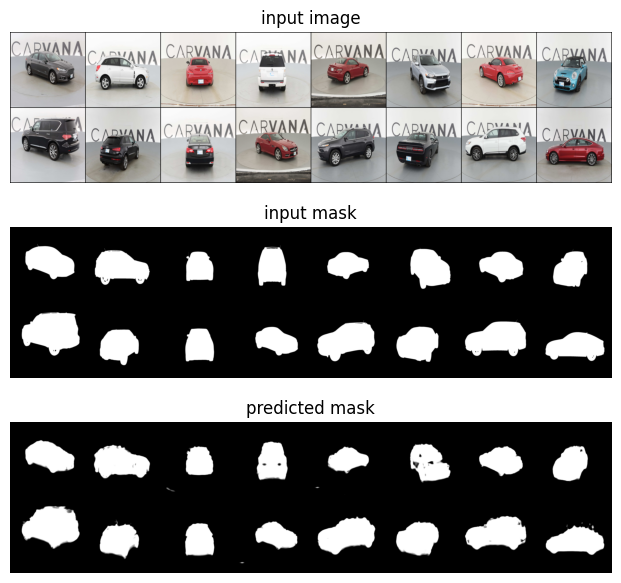

epochs - 9/10 [223/223], dice score: -1.431369890148441, train loss: 0.1510524431018017, val loss: 0.1517311210433642


100%|███████████████████████████████████████████| 96/96 [00:25<00:00,  3.74it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


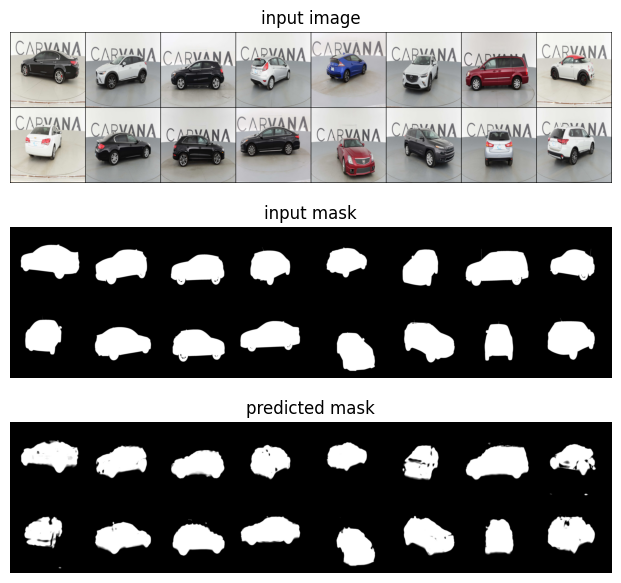

epochs - 10/10 [223/223], dice score: -1.228940858816107, train loss: 0.14856715660726008, val loss: 0.15366913517937064


In [22]:
epochs = 10
learning_rate = 0.0001

model = UNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

history = train(model, optimizer, criterion, scheduler)

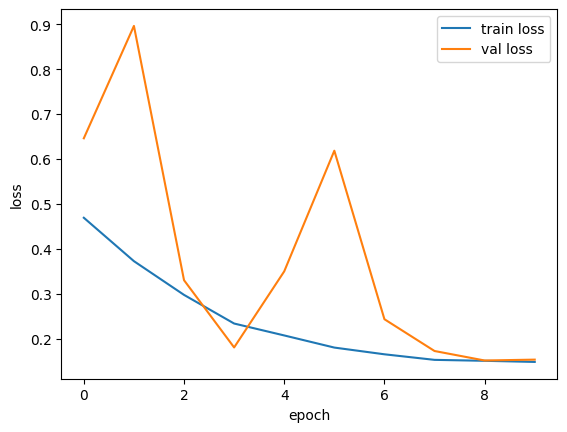

In [23]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['valid_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show();

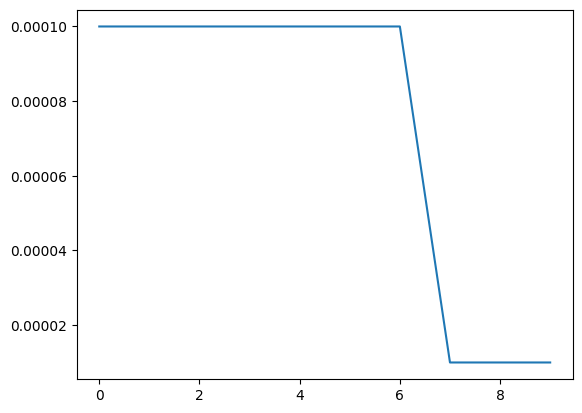

In [24]:
plt.plot(history['lr'])

[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)